In [1]:
# 引入库
from technical_analysis_patterns import (rolling_patterns2pool,plot_patterns_chart)
from typing import (List, Tuple, Dict, Callable, Union)
from tqdm.notebook import tqdm
import json

from jqdatasdk import (auth,get_price,get_trade_days,finance,query,get_industries)

import pandas as pd
import numpy as np
import empyrical as ep


import seaborn as sns
import matplotlib as mpl
import mplfinance as mpf 
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号

auth('','')

D:\anaconda3\lib\site-packages\empyrical\utils.py:32: UserWarning: Unable to import pandas_datareader. Suppressing import error and continuing. All data reading functionality will raise errors; but has been deprecated and will be removed in a later version.
  warnings.warn(msg)


auth success 


# 论文介绍

《Foundations of Technical Analysis》
>Andrew W Lo、Harry Mamaysky和王江提出了一种系统化和自动化的方法，使用非参数核回归方法来进行模式识别，并将该方法应用于1962年至 1996 年的美股数据，以评估技术分析的有效性。通过将股票收益的无条件经验分布与条件分布（给定特定的技术指标，例如：头肩底形态、双底形态）作比较，发现在 31 年的样本期 间内，部分技术指标确实提供了有用的信息，具有实用价值。
>与基本面分析不同，技术分析一直以来饱受争议。然而一些学术研究表明，技术分析能从市场价格中提取 有用的信息。例如，Lo and MacKinlay (1988, 1999)证实了每周的美股指数并非随机游走，过去的价格可以在某种 程度上预测未来收益。技术分析和传统金融工程的一个重要区别在于，技术分析主要通过观察图表进行，而量化金融则依赖于相对完善的数值法。因此，技术分析利用几何工具和形态识别，而量化金融运用数学分析和概率统计。随着近年来金融工程、计算机技术和数值算法等领域的突破，金融工程可以逐步取代不那么严谨的技术分析。技术分析虽饱受质疑却仍能占据一席之地，归功于其视觉分析模式更贴近直观认知，而且在过去，要进行技术分析，首先要认识到价格过程是非线性的，且包含一定的规律和模式。为了定量地捕捉这种规 律，我们首先假定价格过程尚未有严格的算法取代传统的技术分析，如今，成熟的统计算法能够取代传统的几何画图，让技术分析继续以 更新、更严谨的方式服务投资者，同时金融工程领域在分析范式上也得到了丰富。

# 形态识别算法
## 核估计方法

假定价格过程${P_t}$有如下表达形式:

$$P_t=m(X_t)+\epsilon_t,t=1,\dots,T$$

其中$X_t$是状态变量,$m(X_t)$是任意固定但位置的非线性函数,$\epsilon$为白噪声。

为了识别模式,我们令状态变量等于时间$X_{t}=t$,此时,需要用一个光滑函数$\hat{m}(.)$.近似价格过程为了与核回归估计文献中的符号保持一致，我们仍将状态变量记为$X_{t}$。

$\hat{m}(.)$,还需要一个形态识别的算法,以自动识别指数指标。一旦有了算法,就可以应用于不同时段的资产价格,从而评估不同技术指标的有效性。

## 平滑估计量

$\hat{m}=\frac{1}{T}\sum^{T}_{t=1}w_{t}(x)P_{t}$
其中离x较近的$X_t$对应的$P_t$拥有较大的权重$w_{t}(x)$。对于距离的选择，太宽会导致估计量过于平滑而无法显示出$m(⋅)$真正的特性，太窄又会导致估计量的波动较大，无法排除噪声的影响。因此需要通过选择合适的权重$w_{t}(x)$来平衡以上两点。

## 核回归

对于核回归估计量，权重$w_{t}(x)$是通过核密度函数$K(x)$构造的:

$$K(x) \ge 0,\int{K(\mu)}du=1$$

我们可以通过一个参数$h \gt 0$来调整核函数的离散程度,令:

$$K_{h}(x)\equiv\frac{1}{h}K(\mu / h),\int{K_{h}(\mu)du}=1$$

然后定义如下权重系数:

$$w_{t,h}(x) \equiv K_{h}(x-X_{t})/g_{h}(x)$$
$$g_{h}(x) \equiv \frac{1}{T}\sum^{T}_{t=1}K_{h}(x-X_t)$$

其中,平滑系数h也称为带宽,h越大,用于计算加权均值的样本窗口宽度越大。带宽的选取对于任一局部平均方法都很关键，将在下一小节中进行详细讨论。

将上式代入,得到$m(x)$的估计$\hat{m}_{h}(x)$,称为Nadaraya-Waston核估计:

$$\hat{m}_{h}(x)=\frac{1}{T}\sum^{T}_{t=1}w_{t,h}(x)Y_t=\frac{\sum^{T}_{t=1}K_{h}(x-X)Y_t}{\sum^{T}_{t=1}K_{h}(x-X_t)}$$

在特定条件下可以证明，当样本量增大，$\hat{m}_{h}(x)$以多种方式渐进收敛于$m(x)$。该收敛性质对许多核函数都成立，本文将使用最常用的高斯核：

$$K_{h}(x)=\frac{1}{h\sqrt{2\pi}}e^{-x^{2}/2h^{2}}$$

### 带宽(bw)的选择

通过最小化如下函数来选取合适的h:

$$CV(h)=\frac{1}{T}\sum^{T}_{t=1}(P_t-\hat{m}_{h,t})^2$$

其中:

$\hat{m}_{h,t}=\frac{1}{T}\sum^{T}_{t=1}w_{r,h}Y_{r}$

估计量$\hat{m}_{h,t}$是剔除第t个观测得到的估计量，而上式是所有$\hat{m}_{h,t}$的均方误差。对给定的带宽h，CV(h)衡量了核回归估计量的拟合能力。通过最小化CV(h),我们得到的估计量具有一些统计上的优良性质，例如最小渐进均方误差。但由此得到的带宽往往偏大，即基于最小化CV(h) 的$\hat{m}(⋅)$ 给远距离样本过多的权重，导致过渡平滑，丢失了局部信息。经过不断的试验，我们发现最优带宽应取0.3*$h^{*}$,其中$h^{*}=\mathop{argmin}_{h}CV(X)$

### 形态识别算法

1. 头肩形态（头肩顶和头肩底）

$$
HS = 
    \begin{cases}
        E_1\ is\ maximum,  \\
        E_3 > E_1,E_3>E_4, \\ 
        E_1,E_5 \in{[98.5\%,101.05\%]*\frac{E_1+E_5}{2}},\\
        E_2,E_4 \in{[98.5\%,101.05\%]*\frac{E_2+E_5}{2}},\\
    \end{cases}
$$


$$
IHS = 
    \begin{cases}
        E_1\ is\ minimum,  \\
        E_3 < E_1,E_3<E_4, \\ 
        E_1,E_5 \in{[98.5\%,101.05\%]*\frac{E_1+E_5}{2}},\\
        E_2,E_4 \in{[98.5\%,101.05\%]*\frac{E_2+E_5}{2}},\\
    \end{cases}
$$

2. 发散形态（顶部发散和底部发散）
$$
BTOP = 
    \begin{cases}
        E_1\ is\ maximum,  \\
        E_1 < E_3 <E_5, \\ 
        E_2>E_4,\\
    \end{cases}
$$

$$
BBOP = 
    \begin{cases}
        E_1\ is\ minimum,  \\
        E_1 > E_3 > E_5, \\ 
        E_2<E_4,\\
    \end{cases}
$$

3. 三角形

$$
TTOP = 
    \begin{cases}
        E_1\ is\ maximum,  \\
        E_1 > E_3 > E_5, \\ 
        E_2 <> E_4,\\
    \end{cases}
$$

$$
TBOP = 
    \begin{cases}
        E_1\ is\ minimum,  \\
        E_1 <> E_3 < E_5, \\ 
        E_2 > E_4,\\
    \end{cases}
$$

4. 矩形

$$
RTOP = 
    \begin{cases}
        E_1\ is\ maximum,  \\
        |E_i - \frac{E_1 + E_3 + E_4}{3}| < 0.75\% * \frac{E_1+E_2+E_3}{3},i \in {1,3,5} \\
        |E_i - \frac{E_2 + E_4}{2}| < 0.75\% * \frac{E_2+E_4}{2},i \in {2,4},\\
        min(E_1,E_3,E_5) > max(E_2,E_4)
    \end{cases}
$$

$$
RBOP = 
    \begin{cases}
        E_1\ is\ minimum,  \\
        |E_i - \frac{E_1 + E_3 + E_4}{3}| < 0.75\% * \frac{E_1+E_2+E_3}{3},i \in {1,3,5} \\
        |E_i - \frac{E_2 + E_4}{2}| < 0.75\% * \frac{E_2+E_4}{2},i \in {2,4},\\
        min(E_1,E_3,E_5) < max(E_2,E_4)
    \end{cases}
$$

# 形态识别测试

## 中国宝安

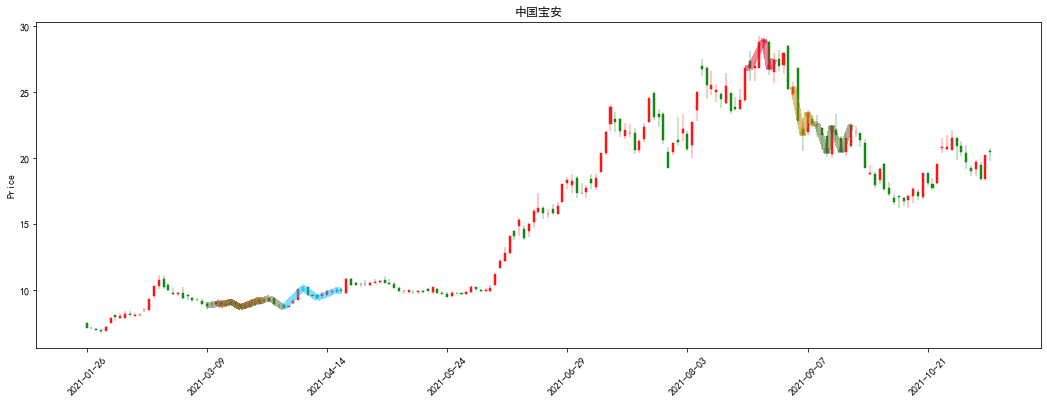

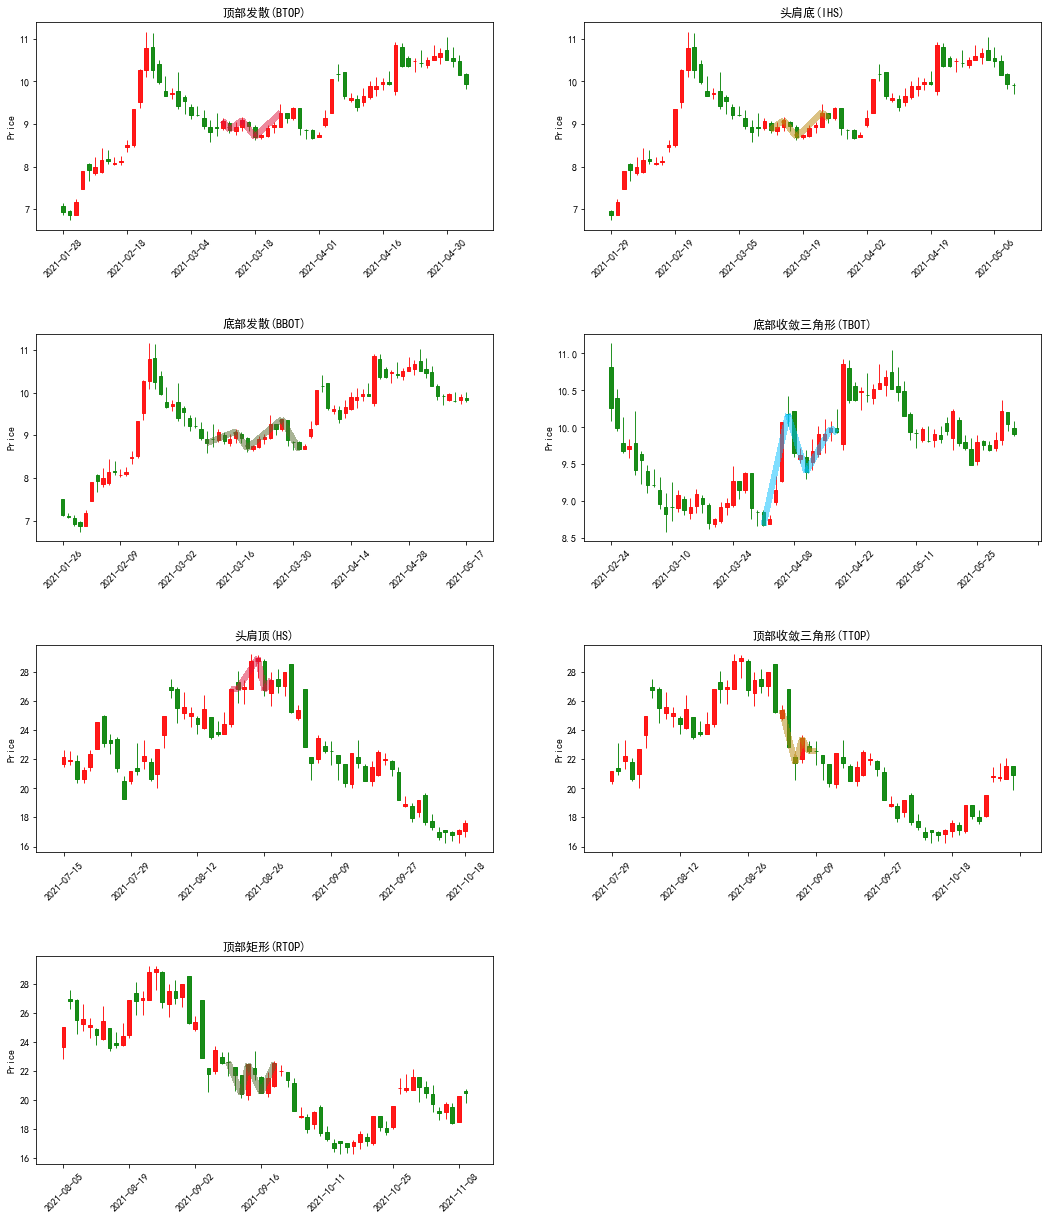

In [4]:
data1 = get_price('000009.XSHE', start_date='2021-01-21', end_date='2021-12-31',
                 fields=['open', 'close', 'low', 'high'], panel=False)

patterns_record1 = rolling_patterns2pool(data1['close'],n=35)

plot_patterns_chart(data1,patterns_record1,True,False)
plt.title('中国宝安')
plot_patterns_chart(data1,patterns_record1,True,True);

## 江淮汽车

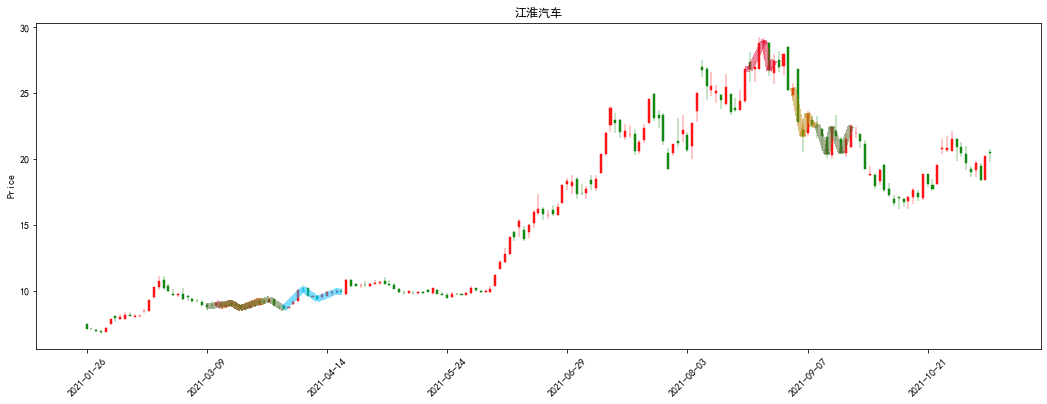

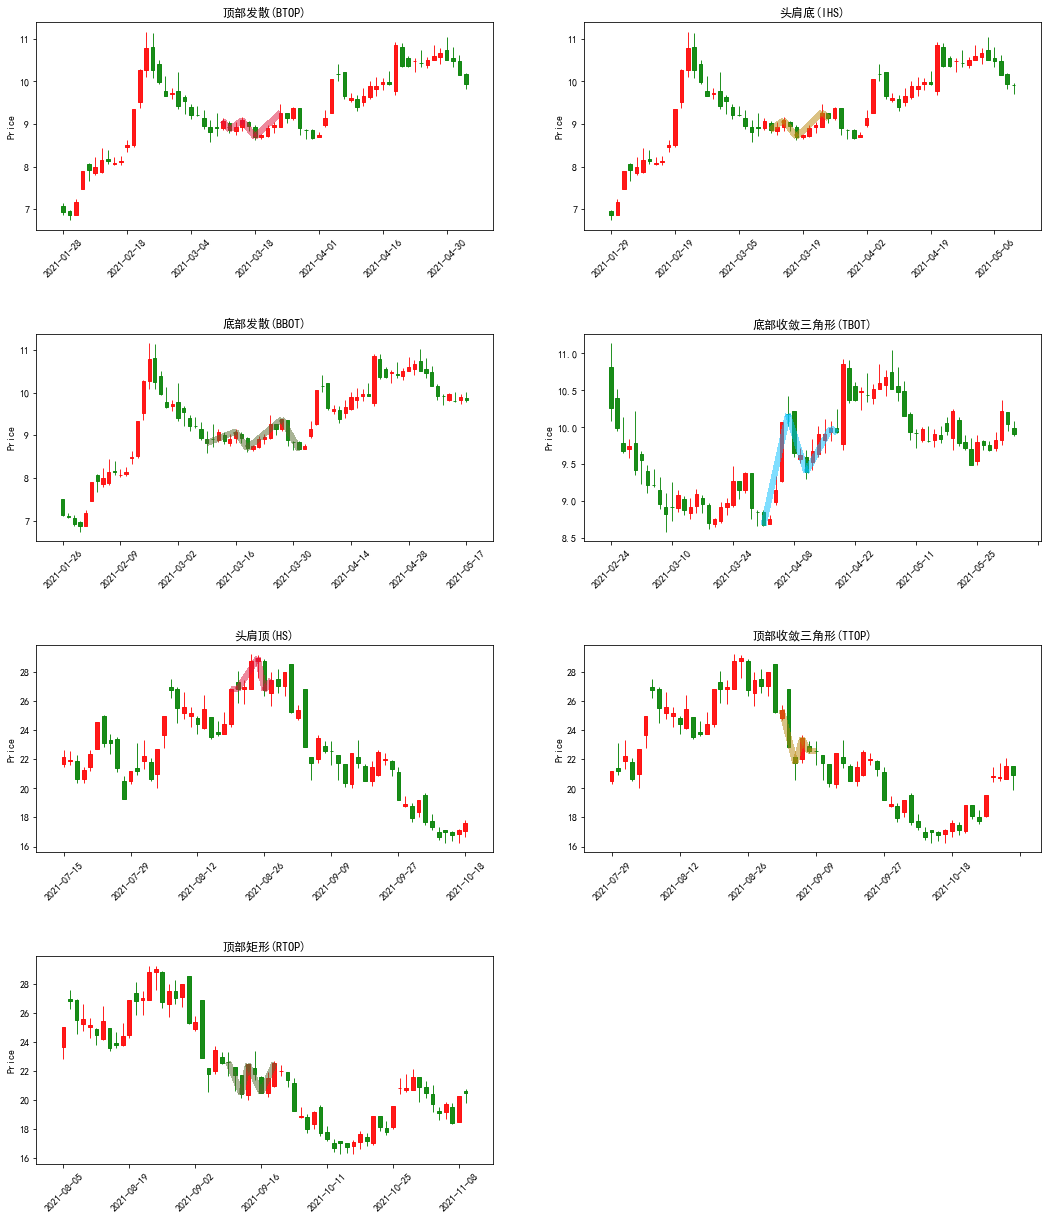

In [6]:
data2 = get_price('600418.XSHG', start_date='2021-01-21', end_date='2021-12-31',
                 fields=['open', 'close', 'low', 'high'], panel=False)

patterns_record2 = rolling_patterns2pool(data1['close'],n=35)

plot_patterns_chart(data1,patterns_record2,True,False)
plt.title('江淮汽车')
plot_patterns_chart(data1,patterns_record2,True,True);

## 沪深300

D:\anaconda3\lib\site-packages\mplfinance\_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


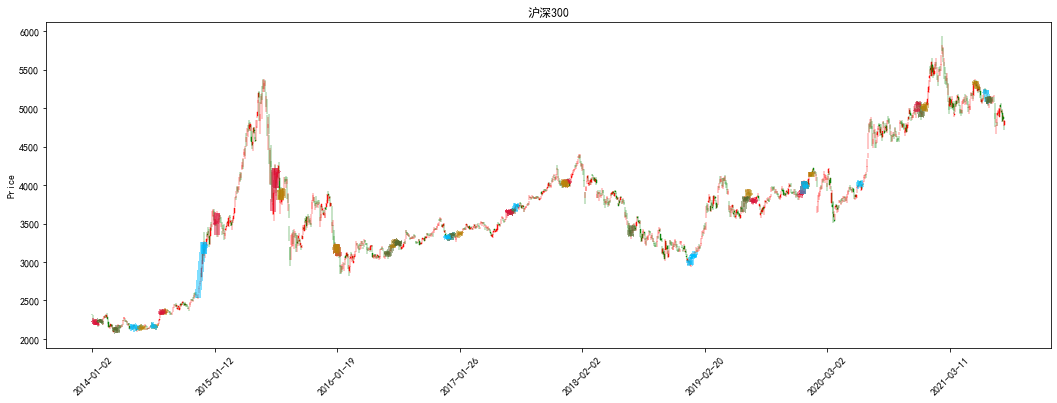

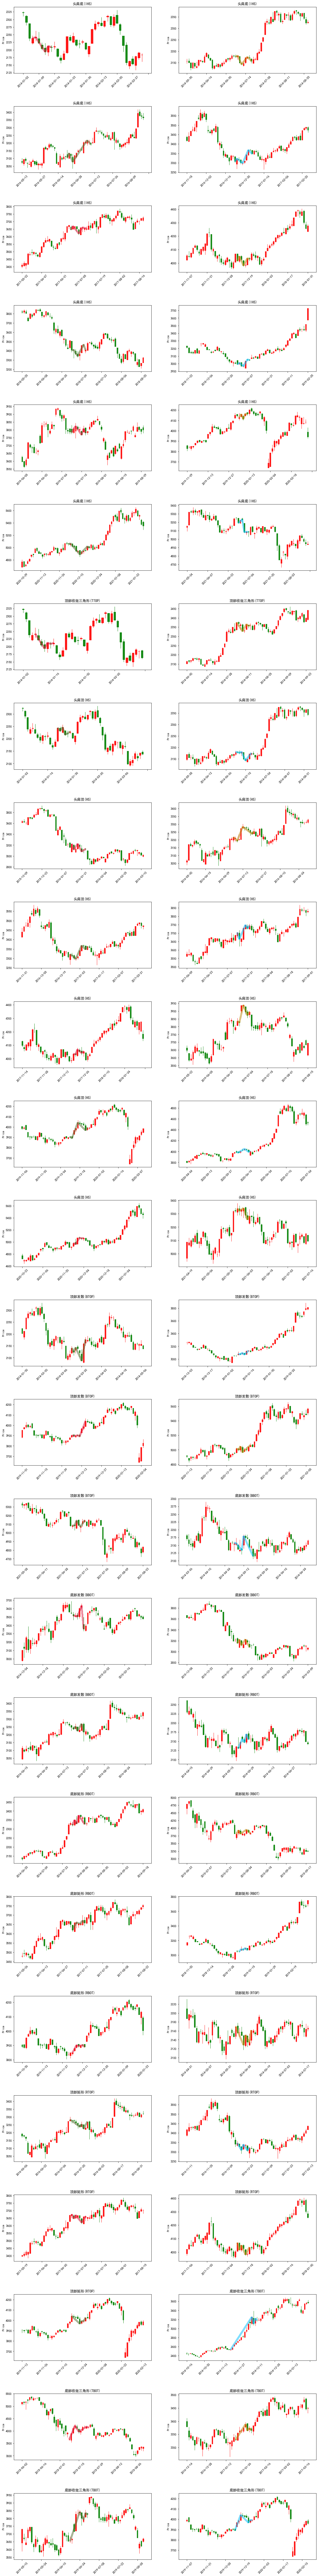

In [10]:
hs300 = get_price('000300.XSHG', start_date='2014-01-01', end_date='2021-12-31',
                 fields=['open', 'close', 'low', 'high'], panel=False)
# 这里周期周期较长 加入reset_window设置字典更新频率
patterns_record3 = rolling_patterns2pool(hs300['close'],n=35,reset_window=120)

plot_patterns_chart(hs300,patterns_record3,True,False)
plt.title('沪深300')
plot_patterns_chart(hs300,patterns_record3,True,True);

# 申万一级行业形态识别情况

In [11]:
def patterns_res2json(dic: Dict) -> str:
    """将结果转为json

    Args:
        dic (Dict): 结果字典

    Returns:
        str
    """
    def json_serial(obj):
        """JSON serializer for objects not serializable by default json code"""

        if isinstance(obj, np.datetime64):
            return pd.to_datetime(obj).strftime('%Y-%m-%d')

        if isinstance(obj, np.ndarray):
            return list(map(lambda x: pd.to_datetime(x).strftime('%Y-%m-%d'), obj.tolist()))

    return json.dumps(dic, default=json_serial, ensure_ascii=False)


def pretreatment_events(factor: pd.DataFrame, returns: pd.DataFrame, before: int, after: int) -> pd.DataFrame:
    """预处理事件,将其拉到同一时间

    Args:
        factor (pd.DataFrame): MuliIndex level0-date level1-asset
        returns (pd.DataFrame): index-datetime columns-asset 
        before (int): 事件前N日
        after (int): 事件后N日

    Returns:
        pd.DataFrame: [description]
    """
    all_returns = []
    for timestamp, df in factor.groupby(level='date'):

        equities = df.index.get_level_values('asset')

        try:
            day_zero_index = returns.index.get_loc(timestamp)
        except KeyError:
            continue

        starting_index = max(day_zero_index - before, 0)
        ending_index = min(day_zero_index + after + 1,
                           len(returns.index))

        equities_slice = set(equities)

        series = returns.loc[returns.index[starting_index:ending_index],
                             equities_slice]
        series.index = range(starting_index - day_zero_index,
                             ending_index - day_zero_index)

        all_returns.append(series)

    return pd.concat(all_returns, axis=1)


def get_event_cumreturns(pretreatment_events: pd.DataFrame) -> pd.DataFrame:
    """以事件当日为基准的累计收益计算

    Args:
        pretreatment_events (pd.DataFrame): index-事件前后日 columns-asset

    Returns:
        pd.DataFrame
    """
    df = pd.DataFrame(index=pretreatment_events.index,
                      columns=pretreatment_events.columns)

    df.loc[:0] = pretreatment_events.loc[:0] / pretreatment_events.loc[0] - 1
    df.loc[1:] = pretreatment_events.loc[0:] / pretreatment_events.loc[0] - 1

    return df


def get_industry_price(codes: Union[str, List], start: str, end: str) -> pd.DataFrame:
    """获取行业指数日度数据. 限制获取条数Limit=4000

    Args:
        codes (Union[str,List]): 行业指数代码
        start (str): 起始日
        end (str): 结束日

    Returns:
        pd.DataFrame: 日度数据
    """
    def query_func(code: str, start: str, end: str) -> pd.Series:

        return finance.run_query(query(finance.SW1_DAILY_PRICE).filter(finance.SW1_DAILY_PRICE.code == code,
                                                                       finance.SW1_DAILY_PRICE.date >= start,
                                                                       finance.SW1_DAILY_PRICE.date <= end))

    if isinstance(codes, str):
        codes = [codes]

    return pd.concat((query_func(code, start, end) for code in codes))


def calc_events_ret(ser: pd.Series, pricing: pd.DataFrame, before: int = 3, end: int = 10, group: bool = True) -> Union[pd.Series, pd.DataFrame]:
    """ 计算形态识别前累计收益率情况

    Args:
        ser (pd.Series): _description_
        pricing (pd.DataFrame): 价格数据 index-date columns-指数
        before (int, optional): 识别前N日. Defaults to 3.
        end (int, optional): 识别后N日. Defaults to 10.
        group (bool, optional): 是否分组. Defaults to True.

    Returns:
        Union[pd.Series, pd.DataFrame]
    """
    events = pretreatment_events(ser, pricing, before,  end)

    rets = get_event_cumreturns(events)

    if group:

        return rets.mean(axis=1)

    else:
        return rets


def get_win_rate(df: pd.DataFrame) -> pd.DataFrame:
    """计算胜率

    Args:
        df (pd.DataFrame): index-days columns 

    Returns:
        pd.DataFrame
    """
    return df.apply(lambda x: np.sum(np.where(x > 0, 1, 0)) / x.count(), axis=1)

def get_pl(df:pd.DataFrame)->pd.DataFrame:

    """计算盈亏比

    Returns:
        pd.DataFrame
    """
    return df.apply(lambda x:x[x>0].mean() / x[x<0].mean(),axis=1)

def plot_events_ret(ser: pd.Series, title: str = '', ax=None):
    """绘制事件收益率图

    Args:
        ser (pd.Series): 收益率序列
        ax (_type_, optional):Defaults to None.

    Returns:
        ax
    """
    if ax is None:
        fig, ax = plt.figure(figsize=(18, 4))

    line_ax = ser.plot(ax=ax, marker='o', title=title)

    line_ax.yaxis.set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, pos: '%.2f%%' % (x * 100)))

    line_ax.set_xlabel('天')
    line_ax.set_ylabel('平均收益率')
    ax.axvline(0, ls='--', color='black')

    return ax


In [15]:
# 获取申万一级行业列表
indstries_frame = get_industries(name='sw_l1', date=None)

industry_price = get_industry_price(indstries_frame.index.tolist(),'2014-01-01','2022-02-18')

# 数据储存
industry_price.to_csv('sw_lv1.csv')

In [16]:
# 读取申万一级行业数据
industry_price = pd.read_csv('sw_lv1.csv', index_col=[
                             'name', 'date'], parse_dates=True).drop(columns='Unnamed: 0')

industry_price.head()

In [17]:
# time 2:14:46
## 形态识别数量受窗口期 及 更新字典的窗口 大小影响
dic = {}  # 储存形态识别结果

for name,df in tqdm(industry_price.groupby(level='name')):
  
    if len(df) > 120:

        dic[name] = rolling_patterns2pool(df.loc[name,'close'],35,reset_window = 120)._asdict()

In [18]:
# 将结果储存为json
res_json =patterns_res2json(dic)

# 数据储存
with open('res_json.json','w',encoding='utf-8') as file:

    json.dump(res_json,file)

In [19]:
# 读取 形态识别后的文件
with open('res_json.json','r',encoding='utf-8') as file:

    res_json = json.load(file)

In [13]:
# 获取交易日历
trade_calendar = get_trade_days('2013-06-01','2022-02-21')

idx = pd.to_datetime(trade_calendar)

In [20]:
row_data = []  # 获取形态识别时的时点

res_dic = json.loads(res_json)  # json转为字典

for code,res1 in res_dic.items():

    for pattern_name,point_tuple in res1['patterns'].items():
        
        for p1,p2 in point_tuple:
         
            watch_date = idx.get_loc(p2) + 3 # 模拟三天后识别形态

            row_data.append([code,pattern_name,idx[watch_date]])

# 转为frame格式
stats_df = pd.DataFrame(row_data,columns=['指数','形态','时间'])

stats_df['value'] = 1


factor_df = pd.pivot_table(stats_df,index=['时间','指数'],columns=['形态'],values='value')

factor_df = factor_df.sort_index()

factor_df.index.names = ['date','asset']

pricing = pd.pivot_table(industry_price.reset_index(),
                         index='date', columns='name', values='close')

## 形态识别后前后平均收益情况

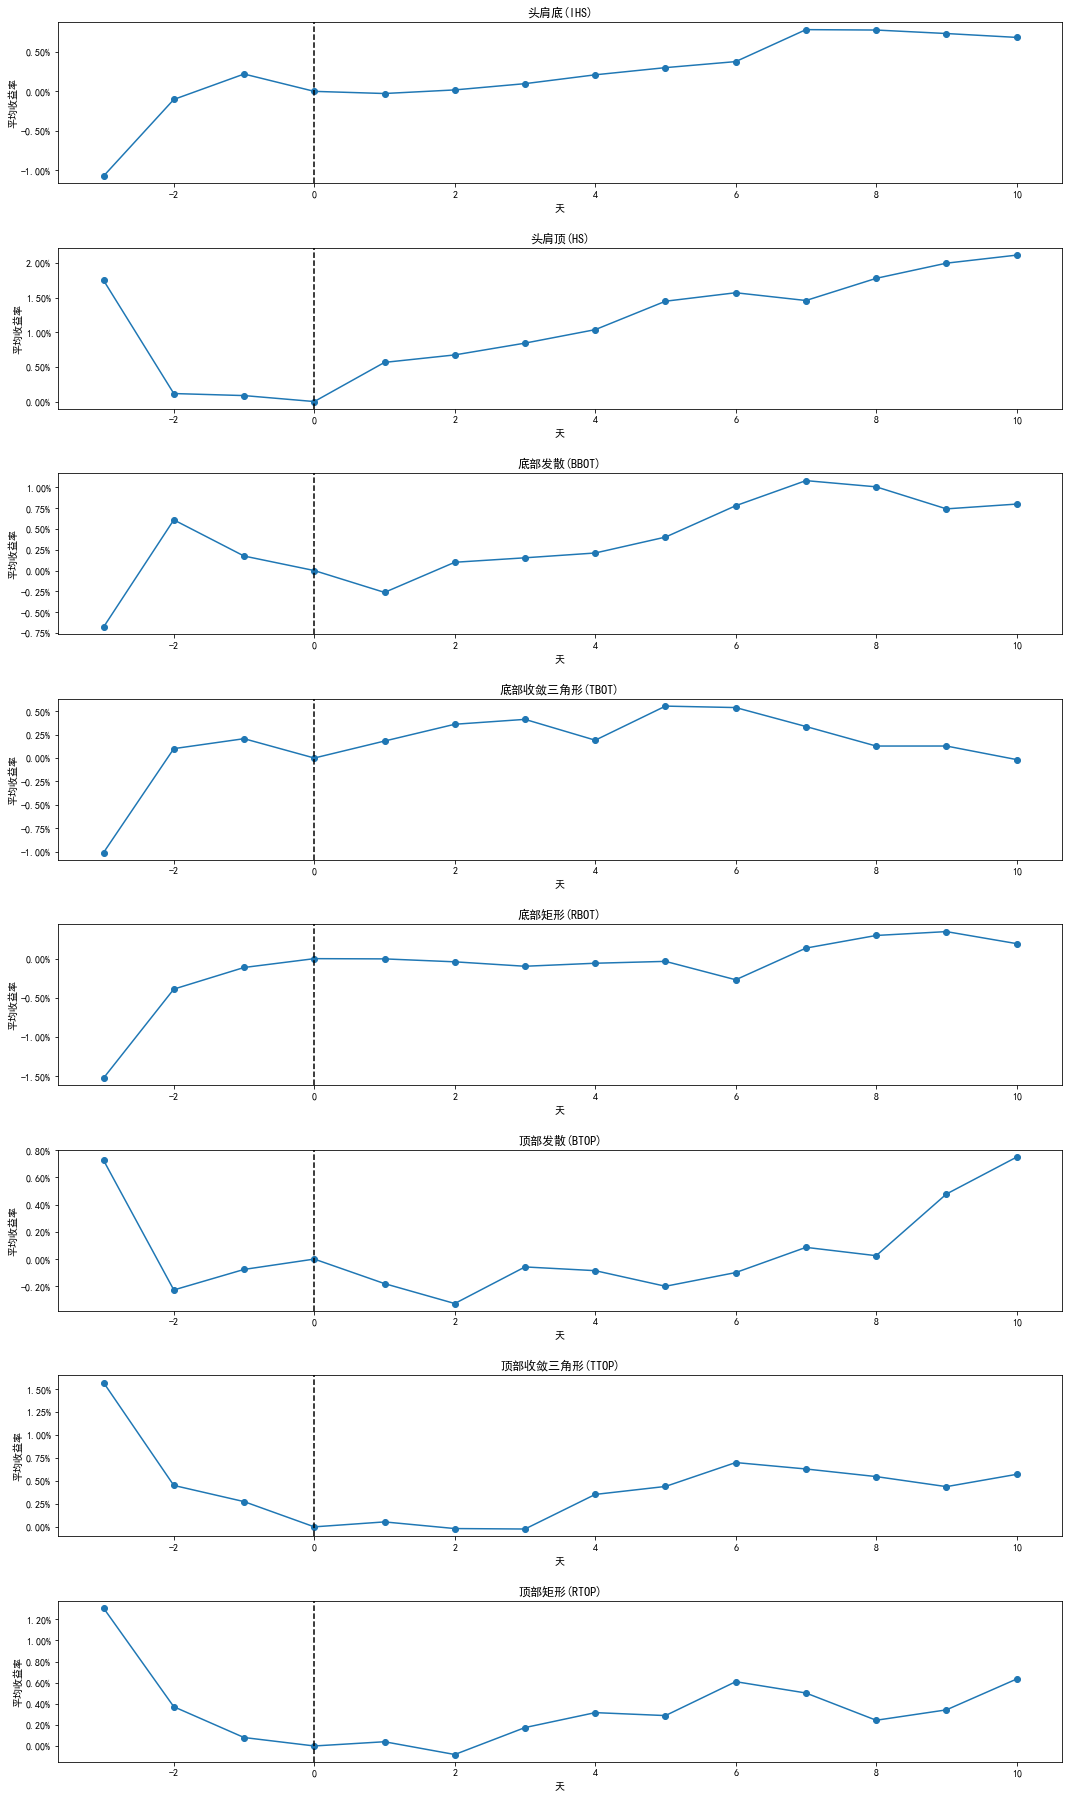

In [21]:
# TODO:收益减去指数自身 评价其超额情况 否则无法真实评价
group_ret = factor_df.groupby(level=0, axis=1).apply(
    lambda x: calc_events_ret(x.dropna(), pricing))

size = group_ret.shape[1]
fig, axes = plt.subplots(size, figsize=(18, 4 * size))

axes = axes.flatten()
for ax, (name, ser) in zip(axes, group_ret.items()):
    plot_events_ret(ser, name, ax)

plt.subplots_adjust(hspace=0.4)

In [22]:
# 计算胜率
evet_ret = factor_df.groupby(level=0, axis=1).apply(
    lambda x: calc_events_ret(x.dropna(), pricing, group=False))


grouped = evet_ret.groupby(level=[0, 1], axis=1)
# 计算胜率
win_ratio = grouped.apply(get_win_rate).loc[[3, 5, 10]].T.swaplevel().sort_index()
# 计算盈亏比
pl_df = grouped.apply(get_pl).loc[[3, 5, 10]].T.swaplevel().sort_index()

win_ratio.columns = pd.MultiIndex.from_tuples([('胜率',3),('胜率',5),('胜率',10)])
pl_df.columns = pd.MultiIndex.from_tuples([('盈亏比',3),('盈亏比',5),('盈亏比',10)])

pattern_count = factor_df.groupby(level=1).sum().stack()
stats = pd.concat((win_ratio,pl_df),axis=1)
stats[('识别次数','All')] = pattern_count

stats

胜率                           盈亏比            \
                           3         5        10         3         5   
name 形态                                                                
交通运输 头肩底(IHS)       0.466667  0.733333  0.533333 -0.674405 -1.107140   
     头肩顶(HS)        0.571429  0.714286  0.714286 -2.367297 -1.834801   
     底部发散(BBOT)     0.666667  0.666667  0.333333 -2.813960 -1.454408   
     底部收敛三角形(TBOT)  0.800000  0.800000  0.400000 -0.554821 -0.557955   
     底部矩形(RBOT)     0.571429  0.428571  0.571429 -1.078427 -2.554149   
...                      ...       ...       ...       ...       ...   
餐饮旅游 底部收敛三角形(TBOT)  0.666667  1.000000  1.000000 -4.359365       NaN   
     底部矩形(RBOT)     0.500000  0.500000  0.500000 -1.089792 -1.087327   
     顶部发散(BTOP)     0.500000  0.500000  0.750000 -1.290124 -1.713131   
     顶部收敛三角形(TTOP)  1.000000  1.000000  1.000000       NaN       NaN   
     顶部矩形(RTOP)     0.500000  0.500000  0.500000 -0.401420 -0.755532   

                              识别次数  
                          10   All  
name 形态                             
交通运输 头肩底(IHS)      -2.052513  15.0  
     头肩顶(HS)       -3.755114  14.0  
     底部发散(BBOT)    -1.197536   3.0  
     底部收敛三角形(TBOT) -1.508219   5.0  
     底部矩形(RBOT)    -0.972385   7.0  
...                      ...   ...  
餐饮旅游 底部收敛三角形(TBOT)       NaN   3.0  
     底部矩形(RBOT)    -1.910532   2.0  
     顶部发散(BTOP)    -2.675643   4.0  
     顶部收敛三角形(TTOP)       NaN   1.0  
     顶部矩形(RTOP)    -3.639606   4.0  

[224 rows x 7 columns]